In [63]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import pandas as pd
import glob
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Path, PathPatch
import numpy as np
from numba import jit

In [2]:
from cpt_convert import loadCPT # Import the CPT convert function
from matplotlib.colors import LinearSegmentedColormap # Linear interpolation for color maps
cpt = loadCPT('dv_anom.cpt')
cpt_convert = LinearSegmentedColormap('cpt', cpt)

In [70]:
@jit(parallel = True)
def plot_tomo(folder, file, depth, v_mode = 1):
    df = pd.read_csv(folder + file,
                 names = ["lon","lat","v"],
                 header = None,
                 delim_whitespace = True)
    df = df[(df['v'] > -20) & (df['v'] < 20)]
    df.v[df.v <= -10] = -9.9
    df.v[df.v >= 10] = 9.9
    lons=np.array(df['lon']) 
    lats=np.array(df['lat']) 
    data=np.array(df["v"])
#    fig, ax = plt.subplots(figsize=(8,10))
    m = Basemap(llcrnrlon=lons.min()-0.05,
                llcrnrlat=lats.min()-0.05,
                urcrnrlon=lons.max()+0.05,
                urcrnrlat=lats.max()+0.05, 
                projection='merc', 
                resolution='i',
                area_thresh=1000.,
                ax = ax)
    x,y = m(lons,lats)
    cs = ax.tricontourf(x,y,data,
                        cmap = cpt_convert,
                        levels=np.linspace(-10,10,50) 
                       )

#     cbar=m.colorbar(cs,location='right')
#     cbarlabels = np.linspace(-10,10,11)
#     cbar.set_ticks(cbarlabels)
#     cbar.set_ticklabels(cbarlabels)
#     cbar.set_label("Velocity anomalies (%)", rotation = 270)
#     cbar.draw_all()
    m.drawcoastlines()
    parallels = np.arange(12,22,1)
    for lat in parallels:
        lon1 = lons.min()-0.1; lon2 = lons.min()+0.02
        lon1, lat1  = m(lon1,lat)
        lon2, lat2  = m(lon2,lat)
        m.plot([lon1,lon2],[lat1,lat2],'k',linewidth=1.5)
    m.drawparallels(parallels,
                    labels=[1,0,0,0],
                    fontsize=14, 
                    linewidth=0.0)
    meridians = np.arange(118,124.5,1)
    for lon in meridians:
        lat1 = lats.min()-0.1; lat2 = lats.min()+0.02
        lon1, lat1  = m(lon,lat1)
        lon2, lat2  = m(lon,lat2)
        m.plot([lon1,lon2],[lat1,lat2],'k',linewidth=1.5)    
    m.drawmeridians(meridians,
                    labels=[0,0,0,1],
                    fontsize=14, 
                    linewidth=0.0)
    fs = 14
    if v_mode == 1:
        ax.set_title("P-wave anomalies depth %s km" %(depth),fontsize = fs)
#        plt.savefig("Plot/horvp_dep" + str(depth) + ".pdf", bbox_inches = "tight")
    elif v_mode == 2:
        ax.set_title("S-wave anomalies depth %s km" %(depth), fontsize=fs)
#        plt.savefig("Plot/horvs_dep" + str(depth) + ".pdf", bbox_inches = "tight")
    if last == True:
        return cs
    else:
        return None    

In [91]:
folder = "../BOARD_N3/hor/"
fl = {"id":range(1,10),
     "dep":range(0,90,10)}
fl['file_vp'] = ["dv15 " + str(s) + ".xyz" for s in fl['id']]
fl['file_vs'] = ["dv25 " + str(s) + ".xyz" for s in fl['id']]
fl = pd.DataFrame(fl)

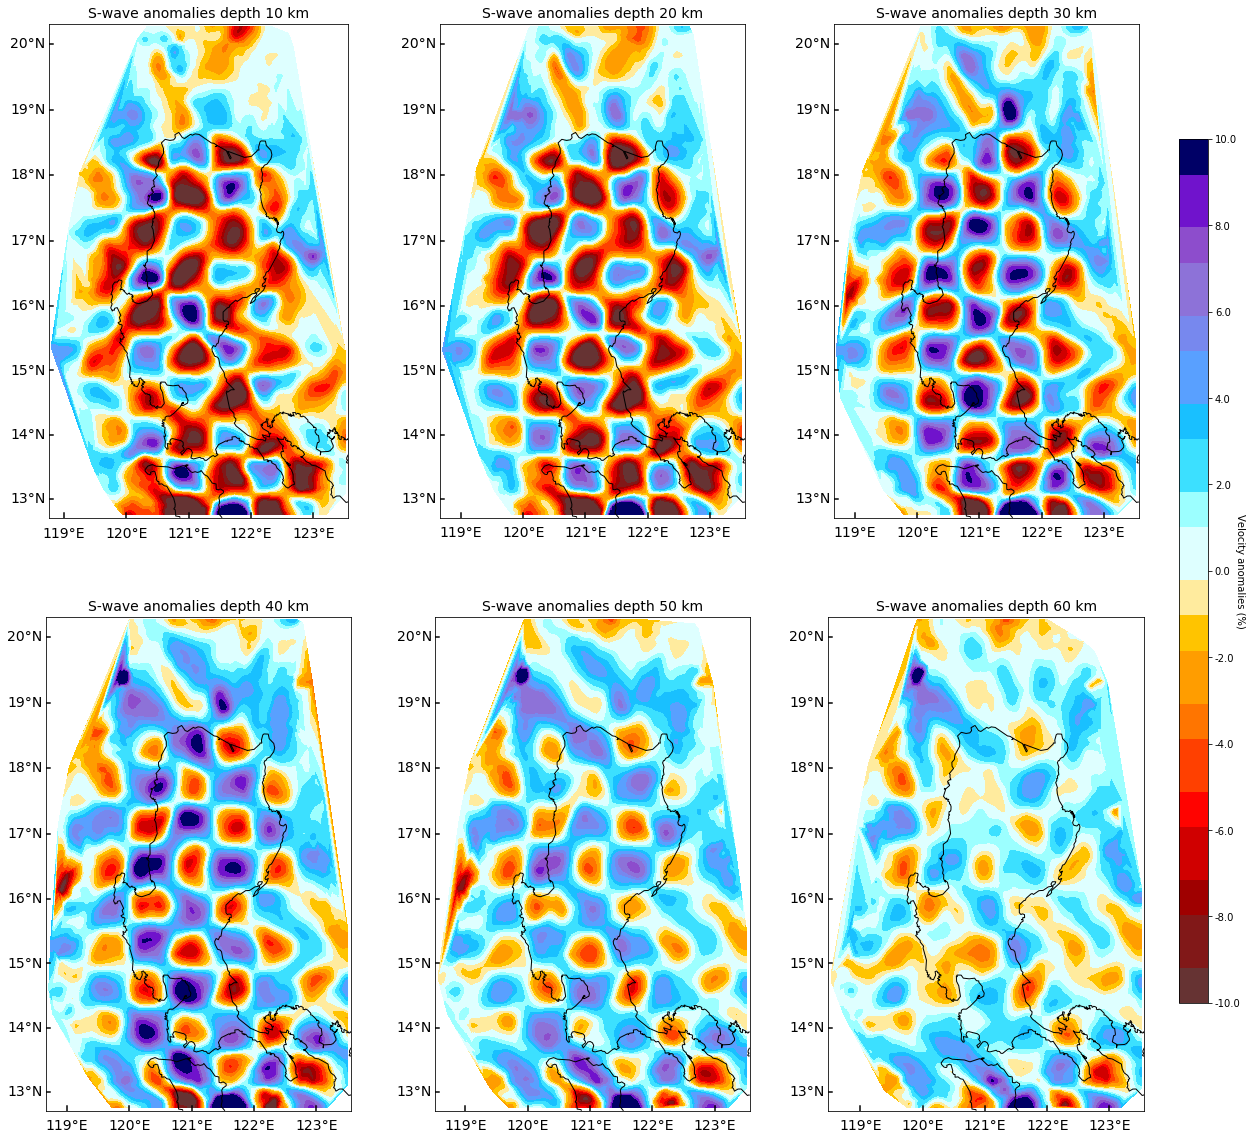

In [93]:
pdepth = [1,2,3,4,5,6]
vmode = 2 #1 for Vp, 2 for Vs
save_folder = "../Plot/CT60/"

fig, axes = plt.subplots(nrows = 2, ncols = 3,figsize = (20,20))
for i,dep in enumerate(pdepth):
    ax = axes.flat[i]
    last = False
    if i == len(pdepth) - 1:
        last = True
    if vmode == 1:
        cs = plot_tomo(folder, fl.file_vp[dep],fl.dep[dep], v_mode = vmode)
    elif vmode == 2:
        cs  = plot_tomo(folder, fl.file_vs[dep],fl.dep[dep], v_mode = vmode)
cbar_ax = plt.gcf().add_axes([0.92, 0.2,0.02,0.6])
cbar=plt.colorbar(cs,cax = cbar_ax)
cbarlabels = np.linspace(-10,10,11)
cbar.set_ticks(cbarlabels)
cbar.set_ticklabels(cbarlabels)
cbar.set_label("Velocity anomalies (%)", rotation = 270)
cbar.draw_all()

if vmode == 1:
#     plt.savefig(save_folder + "horvp_dep" + ".pdf", bbox_inches = "tight")    
    plt.savefig(save_folder + "horvp_dep" + ".jpg", bbox_inches = "tight", dpi = 600)    
if vmode == 2:    
#     plt.savefig(save_folder + "horvp_dep" + ".pdf", bbox_inches = "tight")    
    plt.savefig(save_folder + "horvs_dep" + ".jpg", bbox_inches = "tight", dpi = 600)    

plt.show()